# COGS 108 - EDA Checkpoint

# Names

- Thuy Nguyen
- Tony Hu
- Raul Vargas
- Kristen Corpuz
- Megan Li

<a id='research_question'></a>
# Research Question


How did the pandemic affect multiplayer game (games with social interaction) games available on steam:

- How did the pandemic in 2020 affect player count of the most popular multiplayer games on steam versus the most popular single single player games? What genres and tags were common in games with highest percent increase in player count?

Dataset 1 Name: Application Information (csv file)

Link to the dataset: https://data.mendeley.com/datasets/ycy3sy3vj2/1
Number of observations: 2000
Note that there are 1963 games in the dataset out of the 2000 applications before data cleaning
This dataset has 2000 rows and 5 columns, containing the game ID in the first column and application type, name, release date, and free to play values in the rest of the four columns.

Dataset 2 Name: Application Genres (csv file)

Link to the dataset: https://data.mendeley.com/datasets/ycy3sy3vj2/1
Number of observations: 2000
This dataset has 2000 rows and 2 columns, containing the game ID in the first column and a list of genres corresponding to each game in the second column.

Dataset 3 Name: Application Tags (csv file)

Link to the dataset: https://data.mendeley.com/datasets/ycy3sy3vj2/1
Number of observations: 2000
This dataset has 2000 rows and 2 columns, containing the game ID in the first column and a list of game tags corresponding to each game in the second column.

Dataset 4 Name: Player Count History Part 1 and Player Count History Part 2 (zip files)

Link to the dataset: https://data.mendeley.com/datasets/ycy3sy3vj2/1
Number of observations: 2000 individual csv files corresponding to each game ID
Each Player Count History zip file contains 2000 csv files for each game. Each game’s file has 280,225 rows and 2 columns, containing the date and time in the first column in 5-minute intervals starting from 12/14/2017 12:00 AM to 8/12/2020 11:55 PM and player count for the corresponding date and time in the second column.

Merging the data

We plan to merge datasets 1, 2, and 3 on the game ID using an inner merge and only keeping the rows that exist in all 3 datasets after individually pruning rows in each dataset. After cleaning the top 5 games for selected genres’ (such as single player and multiplayer) player count history files to store monthly averaged player counts starting from January 2019 to August 2020, we may merge this information with our previously combined dataset using the game ID.

# Setup

In [1]:
# importing libraries we might need later
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import datetime
import csv
import glob
import ntpath
import statistics

In [2]:
# Read applicationGenres.csv into dataframe storing only IDs with genres
with open('./datasets/applicationGenres.csv') as f:
    genresDict = {} # Store distinct genres
    IDs = []
    genres = []
    for line in f:
        if ',' in line:
            cleanLine = line.strip().split(',')
            IDs.append(cleanLine[0])
            genres.append(cleanLine[1:])
            for genre in cleanLine[1:]: genresDict.setdefault(genre)
df_genre = pd.DataFrame({'ID':IDs, 'Genres':genres},)
df_genre["ID"] = pd.to_numeric(df_genre["ID"])
df_genre

,ID,Genres
0,578080,"[Action, Adventure, Massively Multiplayer]"
1,570,"[Action, Free to Play, Strategy]"
2,730,"[Action, Free to Play]"
3,359550,[Action]
4,271590,"[Action, Adventure]"
...,...,...
1827,64000,[Strategy]
1828,227860,"[Indie, Strategy]"
1829,429050,"[Action, Indie, Simulation, Early Access]"
1830,209650,[Action]


Using one-hot encoding to separate genres into their own columns instead of having them listed as list of genres for every observation like the table above. Every genre column will be marked with 1 if it is present in the original list of genres for each observation.

In [3]:
df_genre = df_genre.drop('Genres', 1).join(df_genre.Genres.str.join('|').str.get_dummies())
df_genre

,ID,60,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Early Access,Education,...,Racing,Sexual Content,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Violent,Web Publishing
0,578080,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,570,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,730,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,359550,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,271590,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1827,64000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1828,227860,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1829,429050,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1830,209650,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we will look at all columns that has at least one observation with a value 1 for df_genres.

In [4]:
(df_genre.loc[:, df_genre.columns != 'ID'] > 0).any()

60                       True
Action                   True
Adventure                True
Animation & Modeling     True
Audio Production         True
Casual                   True
Design & Illustration    True
Early Access             True
Education                True
Free to Play             True
Gore                     True
Indie                    True
Massively Multiplayer    True
Nudity                   True
Photo Editing            True
RPG                      True
Racing                   True
Sexual Content           True
Simulation               True
Software Training        True
Sports                   True
Strategy                 True
Utilities                True
Video Production         True
Violent                  True
Web Publishing           True
dtype: bool

It seems like all columns of different genres have at least one observation that has a value of 1. However, we will be dropping the column labeled '60' due its ambiguity and legen-related explanation from the source.

In [5]:
df_genre.drop('60', inplace=True, axis=1)
print(list(df_genre.columns))
df_genre.shape

['ID', 'Action', 'Adventure', 'Animation & Modeling', 'Audio Production', 'Casual', 'Design & Illustration', 'Early Access', 'Education', 'Free to Play', 'Gore', 'Indie', 'Massively Multiplayer', 'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Simulation', 'Software Training', 'Sports', 'Strategy', 'Utilities', 'Video Production', 'Violent', 'Web Publishing']


(1832, 26)

Next we will be importing data from the file "applicationInformation.csv".

In [6]:
# Get the applicationInformation.csv and remove rows that are not games and empty
df_info = pd.read_csv("./datasets/applicationInformation.csv", engine="python")
# renaming the appid column to ID, matching the ID column for df_genre
df_info = df_info.rename(columns={'appid': 'ID'})
print(df_info.shape)
df_info

(2000, 5)


,ID,type,name,releasedate,freetoplay
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0
1,570,game,Dota 2,9-Jul-13,1.0
2,730,game,Counter-Strike: Global Offensive,21-Aug-12,1.0
3,622590,NaN,PLAYERUNKNOWN'S BATTLEGROUNDS (Test Server),NaN,NaN
4,359550,game,Tom Clancy's Rainbow Six Siege,1-Dec-15,0.0
...,...,...,...,...,...
1995,34000,advertising,Football Manager 2010,29-Oct-09,1.0
1996,202480,NaN,Skyrim Creation Kit,NaN,NaN
1997,429050,game,Feed and Grow: Fish,8-Jan-16,0.0
1998,209650,game,Call of Duty: Advanced Warfare,3-Nov-14,0.0


Since we will only be exploring data about video games, we will be dropping any observations with a non-game for the "type" column

In [7]:
df_info = df_info[df_info.type == 'game']
df_info

,ID,type,name,releasedate,freetoplay
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0
1,570,game,Dota 2,9-Jul-13,1.0
2,730,game,Counter-Strike: Global Offensive,21-Aug-12,1.0
4,359550,game,Tom Clancy's Rainbow Six Siege,1-Dec-15,0.0
5,271590,game,Grand Theft Auto V,13-Apr-15,0.0
...,...,...,...,...,...
1993,64000,game,Men of War: Assault Squad,24-Feb-11,0.0
1994,227860,game,Castle Story,17-Aug-17,0.0
1997,429050,game,Feed and Grow: Fish,8-Jan-16,0.0
1998,209650,game,Call of Duty: Advanced Warfare,3-Nov-14,0.0


Next we will be importing data from the file "applicationTags.csv".

In [8]:
with open('./datasets/applicationTags.csv') as f:
    tagDict = {} # Store distinct genres
    IDs = []
    tags = []
    for line in f:
        if ',' in line:
            cleanLine = line.strip().split(',')
            IDs.append(cleanLine[0])
            tags.append(cleanLine[1:]) 
            for tag in cleanLine[1:]: tagDict.setdefault(tag)
df_tags = pd.DataFrame({'ID':IDs, 'Tags':tags},)
df_tags["ID"] = pd.to_numeric(df_tags["ID"])

Again, using one-hot encoding to separate tags into their own columns.

In [9]:
df_tags = df_tags.drop('Tags', 1).join(df_tags.Tags.str.join('|').str.get_dummies())
df_tags

,ID,1980s,1990's,2.5D,2D,2D Fighter,3D,3D Platformer,3D Vision,4 Player Local,...,Warhammer 40K,Web Publishing,Werewolves,Western,Word Game,World War I,World War II,Wrestling,Zombies,e-sports
0,578080,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,570,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,730,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,359550,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,271590,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,64000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1941,227860,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1942,429050,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1943,209650,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Since the ID column is the consistent way of identifying the applications listed, we will merge all 3 datasets into 1 joint dataset to provide more accesibility for data analysis and exploration. "df_genre" has the lowest amount of observations, therefore, we will use its amount of observations as the lower bound for merging the datasets.

In [10]:
df_genre_tags = pd.merge(df_genre, df_tags,on='ID') # shape = (1825, 365) after merging
combined_df = pd.merge(df_info, df_genre_tags, on='ID') # shape = (1803, 369) after merging
combined_df.shape

(1803, 369)

# Data Cleaning

There are a lot of columns on our final dataset merge. Let's take a look at what those columns are and decide which are most valuable to our research question.

In [11]:
print(list(combined_df.columns))

['ID', 'type', 'name', 'releasedate', 'freetoplay', 'Action_x', 'Adventure_x', 'Animation & Modeling_x', 'Audio Production_x', 'Casual_x', 'Design & Illustration_x', 'Early Access_x', 'Education_x', 'Free to Play_x', 'Gore_x', 'Indie_x', 'Massively Multiplayer_x', 'Nudity_x', 'Photo Editing_x', 'RPG_x', 'Racing_x', 'Sexual Content_x', 'Simulation_x', 'Software Training_x', 'Sports_x', 'Strategy_x', 'Utilities_x', 'Video Production_x', 'Violent_x', 'Web Publishing_x', '1980s', "1990's", '2.5D', '2D', '2D Fighter', '3D', '3D Platformer', '3D Vision', '4 Player Local', '4X', '6DOF', 'Abstract', 'Action_y', 'Action RPG', 'Action-Adventure', 'Addictive', 'Adventure_y', 'Agriculture', 'Aliens', 'Alternate History', 'America', 'Animation & Modeling_y', 'Anime', 'Arcade', 'Arena Shooter', 'Artificial Intelligence', 'Assassin', 'Asynchronous Multiplayer', 'Atmospheric', 'Audio Production_y', 'Base-Building', 'Based On A Novel', 'Basketball', 'Batman', 'Battle Royale', "Beat 'em up", 'Beautiful'

Looking at all the genres and tags we got from combining the 3 data sets, we decided to stick to only ['ID', 'type', 'name', 'releasedate', 'freetoplay', 'Free to Play_x', 'Massively Multiplayer_x', 'Asynchronous Multiplayer', 'Casual_y', 'Co-op', 'Co-op Campaign', 'Competitive', 'Free to Play_y', 'Local Co-Op', 'Local Multiplayer', 'Massively Multiplayer_y', 'Multiplayer', 'Online Co-Op', 'Party-Based RPG', 'PvE', 'PvP', 'RPG_x', 'RPG_y', 'Replay Value', 'Singleplayer']. The reason we chose to do so is because we believe these features may be directly related to our research questions or may be confounders to the variables we may be investigating for our research questions.

In [12]:
combined_reduced = (combined_df[['ID', 'type', 'name', 'releasedate', 'freetoplay', 'Free to Play_x', 'Massively Multiplayer_x', 'Asynchronous Multiplayer', 'Casual_y', 'Co-op', 'Co-op Campaign', 'Competitive', 'Free to Play_y', 'Local Co-Op', 'Local Multiplayer', 'Massively Multiplayer_y', 'Multiplayer', 'Online Co-Op', 'Party-Based RPG', 'PvE', 'PvP', 'RPG_x', 'RPG_y', 'Replay Value', 'Singleplayer', 'Casual_x']]).copy()
combined_reduced

,ID,type,name,releasedate,freetoplay,Free to Play_x,Massively Multiplayer_x,Asynchronous Multiplayer,Casual_y,Co-op,...,Multiplayer,Online Co-Op,Party-Based RPG,PvE,PvP,RPG_x,RPG_y,Replay Value,Singleplayer,Casual_x
0,578080,game,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,0,1,0,0,1,...,1,1,0,0,1,0,0,0,0,0
1,570,game,Dota 2,9-Jul-13,1.0,1,0,0,0,1,...,1,1,0,0,1,0,1,1,0,0
2,730,game,Counter-Strike: Global Offensive,21-Aug-12,1.0,1,0,0,0,1,...,1,1,0,0,1,0,0,0,0,0
3,359550,game,Tom Clancy's Rainbow Six Siege,1-Dec-15,0.0,0,0,0,1,1,...,1,1,0,0,0,0,0,0,1,0
4,271590,game,Grand Theft Auto V,13-Apr-15,0.0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798,64000,game,Men of War: Assault Squad,24-Feb-11,0.0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1799,227860,game,Castle Story,17-Aug-17,0.0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,1,0
1800,429050,game,Feed and Grow: Fish,8-Jan-16,0.0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1801,209650,game,Call of Duty: Advanced Warfare,3-Nov-14,0.0,0,0,0,0,1,...,1,1,0,0,1,0,0,0,1,0


Looking at the remaining columns, we decide to drop the "type" column due to it having only one type which is "game."

In [13]:
combined_reduced.drop('type', inplace=True, axis=1) # dropping type column

Next we will look for any NaN's values and see if we can fix or drop any of the observations with NaN. 

In [14]:
combined_reduced.isna().any()

ID                          False
name                        False
releasedate                  True
freetoplay                  False
Free to Play_x              False
Massively Multiplayer_x     False
Asynchronous Multiplayer    False
Casual_y                    False
Co-op                       False
Co-op Campaign              False
Competitive                 False
Free to Play_y              False
Local Co-Op                 False
Local Multiplayer           False
Massively Multiplayer_y     False
Multiplayer                 False
Online Co-Op                False
Party-Based RPG             False
PvE                         False
PvP                         False
RPG_x                       False
RPG_y                       False
Replay Value                False
Singleplayer                False
Casual_x                    False
dtype: bool

The 'releasedate' column seems to be the only one with missing values. Let's look at which rows have missing values for this column.

In [15]:
combined_reduced[combined_reduced['releasedate'].isna()]

,ID,name,releasedate,freetoplay,Free to Play_x,Massively Multiplayer_x,Asynchronous Multiplayer,Casual_y,Co-op,Co-op Campaign,...,Multiplayer,Online Co-Op,Party-Based RPG,PvE,PvP,RPG_x,RPG_y,Replay Value,Singleplayer,Casual_x
126,219740,Don't Starve,NaN,0.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
823,272230,Sub Rosa,NaN,0.0,0,0,0,1,1,0,...,1,1,0,0,0,0,0,0,0,0
829,224540,Ace of Spades,NaN,1.0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,1,0,0
938,223850,3DMark,NaN,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
943,212480,Sonic & All-Stars Racing Transformed,NaN,0.0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,1,1,0
978,237110,Mortal Kombat Komplete Edition,NaN,0.0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,1,0
1234,564310,Serious Sam Fusion 2017 (beta),NaN,0.0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1268,214560,Mark of the Ninja,NaN,1.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
1271,202170,Sleeping Dogs�,NaN,1.0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0
1570,39550,SpellForce 2 - Anniversary Edition,NaN,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0


Let's see what datatype the cells under the 'releasedate' columns are so we can properly fix our missing values problem.

In [16]:
type(combined_reduced['releasedate'].iloc[0])

str

Researching on our own, we were able to find the release dates missing for the applications above. Since we wanted to be consistent, we are pulling release dates straight from Steam. However, the following games' release dates were delisted from Steam, so we had to pull the release dates from Google. There was also a game removed from Steam by its publisher's request (Warner Bros.). From checking the type, release date is of type str. We will be inputting the missing release dates as str following the convention of other release dates from the data frame and convert the entire column to date time later. 
Games with release date delisted from Steam:
- Don't Starve
- Mortal Kombat Komplete Edition (removed from Steam on March 21 2020)
- Serious Sam Fusion 2017
- Mark of the Ninja
- Sleeping Dogs
We also discovered that 3D Mark is not a game but a bench marking application, therefore, we will be removing it from the reduced data set. 

In [17]:
# Setting the releasedate
combined_reduced.at[126, 'releasedate'] = '23-Apr-13'
combined_reduced.at[823, 'releasedate'] = '25-Mar-21'
combined_reduced.at[829, 'releasedate'] = '12-Dec-12'
combined_reduced.at[943, 'releasedate'] = '20-Feb-13'
combined_reduced.at[978, 'releasedate'] = '19-Apr-11'
combined_reduced.at[1234, 'releasedate'] = '21-Mar-17'
combined_reduced.at[1268, 'releasedate'] = '9-Oct-18'
combined_reduced.at[1271, 'releasedate'] = '14-Oct-14'
combined_reduced.at[1570, 'releasedate'] = '29-Oct-09'
combined_reduced.at[1595, 'releasedate'] = '5-Oct-17'

In [18]:
# removing the miscategorized non-game application from the dataset
combined_reduced.drop(combined_reduced.index[938], inplace=True)
combined_reduced = combined_reduced.reset_index(drop=True)
combined_reduced

,ID,name,releasedate,freetoplay,Free to Play_x,Massively Multiplayer_x,Asynchronous Multiplayer,Casual_y,Co-op,Co-op Campaign,...,Multiplayer,Online Co-Op,Party-Based RPG,PvE,PvP,RPG_x,RPG_y,Replay Value,Singleplayer,Casual_x
0,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,21-Dec-17,0.0,0,1,0,0,1,0,...,1,1,0,0,1,0,0,0,0,0
1,570,Dota 2,9-Jul-13,1.0,1,0,0,0,1,0,...,1,1,0,0,1,0,1,1,0,0
2,730,Counter-Strike: Global Offensive,21-Aug-12,1.0,1,0,0,0,1,0,...,1,1,0,0,1,0,0,0,0,0
3,359550,Tom Clancy's Rainbow Six Siege,1-Dec-15,0.0,0,0,0,1,1,0,...,1,1,0,0,0,0,0,0,1,0
4,271590,Grand Theft Auto V,13-Apr-15,0.0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,64000,Men of War: Assault Squad,24-Feb-11,0.0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1798,227860,Castle Story,17-Aug-17,0.0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,1,0
1799,429050,Feed and Grow: Fish,8-Jan-16,0.0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1800,209650,Call of Duty: Advanced Warfare,3-Nov-14,0.0,0,0,0,0,1,0,...,1,1,0,0,1,0,0,0,1,0


Since the inputs for the release date are not consistenly format to work with the DateTime library, we need to add leading 0's to single digit days.

In [19]:
missing_dates = []
for (key, date) in combined_reduced['releasedate'].iteritems():
    if len(date) == 8:
        date = "0" + date
        combined_reduced.at[key, 'releasedate'] = date
    elif len(date) < 8:
        missing_dates.append(key)

names = []
for key in missing_dates:
    names.append(combined_reduced.iloc[key]['name'])

In [20]:
combined_reduced.at[130, 'releasedate'] = '01-Jun-15' # used google with june as key search term
combined_reduced.at[217, 'releasedate'] = '18-Nov-14' # from steam
combined_reduced.at[362, 'releasedate'] = '01-Oct-15' # original date and moth were also in consisten with steam, so date has been directly grabbed form steam
combined_reduced.at[385, 'releasedate'] = '01-Jul-14' # used google with july as key search term
combined_reduced.at[1070, 'releasedate'] = '27-Aug-14' # used google with aug as key search term
combined_reduced.at[1344, 'releasedate'] = '07-Jul-16' # used google with july as key search term
combined_reduced.at[1762, 'releasedate'] = '06-Dec-16' # used google with december and 2012 as key search term

Now that all the 'releasedate' missing values have been filled and all the values under this columns have been fixed to carry a consistent writing convention, let's convert them to DateTime type for easier analysis later on.

In [21]:
for (key, date) in combined_reduced['releasedate'].iteritems():
    try:
        converted = datetime.datetime.strptime(date, '%d-%b-%y')
        combined_reduced.at[key, 'releasedate'] = converted
    except ValueError:
        print(date)

Next we'll be merging duplicated columns by OR the existing columns and set the result to new column.

In [22]:
# using a convertion dictionary method to convert types of multiple columns at once
convert_dict = {'Free to Play_x': bool,
                'Free to Play_y': bool,
                'freetoplay': bool,
                'Casual_x': bool,
                'Casual_y': bool,
                'RPG_x': bool,
                'RPG_y': bool,
                'Massively Multiplayer_x': bool,
                'Massively Multiplayer_y': bool}
combined_reduced = combined_reduced.astype(convert_dict)

In [23]:
# OR-ing the values of duplicated columsn to get appropriate values
combined_reduced = combined_reduced.assign(free_to_play = (combined_reduced['freetoplay'] | combined_reduced['Free to Play_x'] | combined_reduced['Free to Play_y']))
combined_reduced = combined_reduced.assign(Casual = (combined_reduced['Casual_x'] | combined_reduced['Casual_y']))
combined_reduced = combined_reduced.assign(RPG = (combined_reduced['RPG_x'] | combined_reduced['RPG_y']))
combined_reduced = combined_reduced.assign(Massively_Multiplayer = (combined_reduced['Massively Multiplayer_x'] | combined_reduced['Massively Multiplayer_y']))
combined_reduced['free_to_play'] = combined_reduced['free_to_play'].astype('int')
combined_reduced['Casual'] = combined_reduced['Casual'].astype('int')
combined_reduced['RPG'] = combined_reduced['RPG'].astype('int')
combined_reduced['Massively_Multiplayer'] = combined_reduced['Massively_Multiplayer'].astype('int')
# dropping the duplicated columns
combined_reduced.drop(['Free to Play_x', 'Free to Play_y', 'freetoplay', 'Casual_x', 'Casual_y', 'RPG_x', 'RPG_y', 'Massively Multiplayer_x', 'Massively Multiplayer_y'], inplace=True, axis=1)
combined_reduced

,ID,name,releasedate,Asynchronous Multiplayer,Co-op,Co-op Campaign,Competitive,Local Co-Op,Local Multiplayer,Multiplayer,Online Co-Op,Party-Based RPG,PvE,PvP,Replay Value,Singleplayer,free_to_play,Casual,RPG,Massively_Multiplayer
0,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21 00:00:00,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1
1,570,Dota 2,2013-07-09 00:00:00,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0
2,730,Counter-Strike: Global Offensive,2012-08-21 00:00:00,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0
3,359550,Tom Clancy's Rainbow Six Siege,2015-12-01 00:00:00,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,1
4,271590,Grand Theft Auto V,2015-04-13 00:00:00,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1797,64000,Men of War: Assault Squad,2011-02-24 00:00:00,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1798,227860,Castle Story,2017-08-17 00:00:00,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
1799,429050,Feed and Grow: Fish,2016-01-08 00:00:00,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0
1800,209650,Call of Duty: Advanced Warfare,2014-11-03 00:00:00,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0


In [24]:
# Save the combined and reduced dataframe into a csv file
combined_reduced.to_csv('./datasets/combinedReduced.csv', index=False, header=True)

# Data Analysis & Results (EDA)

In [25]:
sns.set(rc={'figure.figsize':(16.7,8.27)})

Before looking at all the files in the 'playerCount' folders, we wanted to have an in depth look at a smaller set of the data (since the folders contain a huge amount of data) to get a sense of the trends present. We will be focusing on the most 5 most popular single player and the 5 most popular multiplayer games.

## Top 5 Single Player Games Player Count EDA (For checkpoint)

Taking the top 5 single player games, we analyzed their player counts before and after the pandemic. Player counts for each game can be found in the Player Counts History Part 1 folder where filenames correspond to the game ID.

First, we extracted the player count files for these five games, and transformed the 5-minute intervals to 1 day-intervals by taking the average of all the entries for that day. Then, we plot their player counts averaged by day from November 01, 2019 to June 01, 2020, labeling the pandemic start date on the line plot.

In [26]:
def plotGame(ID, startDate, endDate, y_values_dict):
    df = pd.read_csv("./datasets/PlayerCountHistoryPart1/"+str(ID)+".csv")
    df['Date']= pd.to_datetime(df['Time'])
    df = df[(df.Date >= startDate) & (df.Date <= endDate)]
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    df['Date'] = df['Date'].apply(lambda x: x.strftime('%Y-%m'))
    df_tmp = df.groupby('Date').mean()
    df_tmp = df_tmp.reset_index()
    y_values_dict.setdefault(ID, list(df_tmp['Playercount']))
    dates = list(df_tmp['Date']) # find a way to do collect dates once. this is repetitive and dates is constant
    return dates

In [27]:
single_player_IDs = [377160, 489830, 255710, 250900, 264710]
game_ID_dict = {377160:'Fallout 4',
                489830: 'The Elder Scrolls V: Skyrim Special Edition',
                255710: 'Cities: Skylines',
                250900: 'The Binding of Isaac: Rebirth',
                264710: 'Subnautica'}

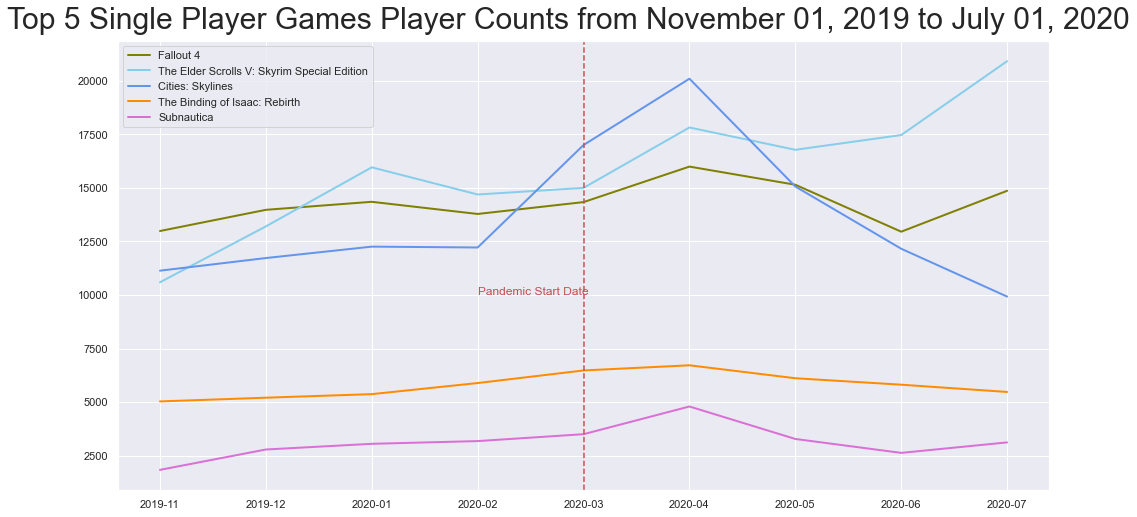

In [28]:
# Range (total range): [Nov 2019, ..., June 2020]
range_start_date = "2019-11-01 00:00:00"
range_end_date   = "2020-07-01 00:00:00"

# Range Line Plot
y_values_dict = {}
for single_player_game in single_player_IDs:
    all_dates = plotGame(single_player_game, range_start_date, range_end_date, y_values_dict)

# Merge all games into one dataframe
all_games_df = pd.DataFrame({ 'Date': all_dates})
for single_id in game_ID_dict.keys():
    all_games_df[game_ID_dict[single_id]] = y_values_dict[single_id]

# Plot each game's player count history (loop)
plt.plot( 'Date', game_ID_dict[377160], data=all_games_df, marker='', color='olive', linewidth=2)
plt.plot( 'Date', game_ID_dict[489830], data=all_games_df, marker='', color='skyblue', linewidth=2) 
plt.plot( 'Date', game_ID_dict[255710], data=all_games_df, marker='', color='cornflowerblue', linewidth=2)
plt.plot( 'Date', game_ID_dict[250900], data=all_games_df, marker='', color='darkorange', linewidth=2)
plt.plot( 'Date', game_ID_dict[264710], data=all_games_df, marker='', color='orchid', linewidth=2)
#plt.title('Top 5 Single Player Games Player Counts from November 01, 2019 to July 01, 2020')
plt.figtext(.5,.9,'Top 5 Single Player Games Player Counts from November 01, 2019 to July 01, 2020', fontsize=30, ha='center')
plt.axvline(x='2020-03', linestyle='--', color = 'r')
plt.text(3,10000,'Pandemic Start Date',color='r',fontsize=12)
plt.legend();

From the line plot above, we can see a dramatic increase in the average player count history for Cities: Skylines, and a less drastic, but peaks nonetheless with the other 4 games around March-April. We suspect that there may be confounding factors such as game sale events on Steam, but the data set does not include information for us to properly investigate it.

In [29]:
# Range 1: [Nov 2019, Dec 2019, Jan 2020, Feb 2020]
range_pre_start_date = "2019-11-01 00:00:00"
range_pre_end_date   = "2020-02-29 00:00:00"

# Range 2: [March 2020, April 2020, May 2020, June 2020]
range_post_start_date = "2020-03-01 00:00:00"
range_post_end_date   = "2020-07-01 00:00:00"

In [30]:
pre_y_values_dict = {} # Collect all y-values for each game

for single_player_game in single_player_IDs:
    dates = plotGame(single_player_game, range_pre_start_date, range_pre_end_date, pre_y_values_dict)

In [31]:
pandemic_y_values_dict = {} # Collect all y-values for each game

for single_player_game in single_player_IDs:
    dates = plotGame(single_player_game, range_post_start_date, range_post_end_date, pandemic_y_values_dict)

In [32]:
def findPercentIncrease(gameID):
    # Find average of player counts from November 2019 to February 2020 for each game
    pre_game = statistics.mean(pre_y_values_dict[gameID])
    # Find average of player counts from March 2020 to June 2020 for each game
    post_game = statistics.mean(pandemic_y_values_dict[gameID])
    perc_increase = (post_game - pre_game) / pre_game * 100
    return perc_increase

In [33]:
# Find percent change for each game (apply function on column)
perc_fallout = findPercentIncrease(377160)
perc_elder_scrolls = findPercentIncrease(489830)
perc_cities_skylines = findPercentIncrease(255710) 
perc_binding_isaac = findPercentIncrease(250900) 
perc_subnautica = findPercentIncrease(264710) 
games_and_perc = {'Game': ['Fallout 4',
                           'The Elder Scrolls V: Skyrim Special Edition',
                           'Cities: Skylines','The Binding of Isaac: Rebirth',
                           'Subnautica'],
                  'Percent Increase in Player Counts': [perc_fallout, 
                            perc_elder_scrolls, 
                            perc_cities_skylines, 
                            perc_binding_isaac, 
                            perc_subnautica] }

Text(0.5, 0.9, 'Percent Increase in Player Counts for 5 Most Popular Single Player Games')

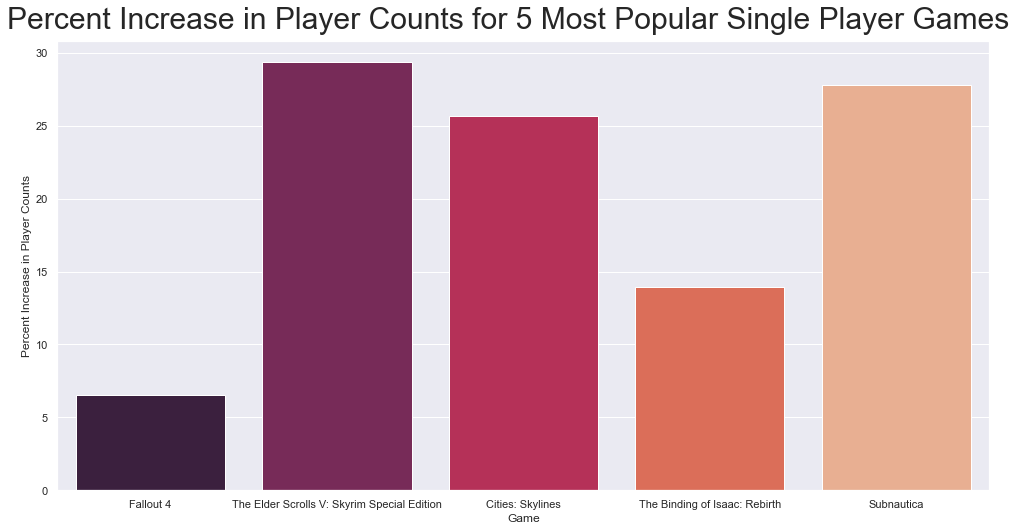

In [34]:
perc_change = pd.DataFrame(games_and_perc, columns=['Game','Percent Increase in Player Counts'])
ax = sns.barplot(x="Game", y="Percent Increase in Player Counts", data=perc_change, palette='rocket')
plt.figtext(.5,.9,'Percent Increase in Player Counts for 5 Most Popular Single Player Games', fontsize=30, ha='center')
#plt.title("Percent Increase in Player Counts for 5 Most Popular Single Player Games")

From the bar plot above we see a percentage increase ranging from 7% to almost 30% between the pre to post pandemic time periods for the most popular 5 single player games rated on Steam.

Next we will be taking an in-depth loko at the same data for the most popular Multiplayer games as rated on Steam.

In [35]:
multi_player_IDs = [730, 570, 578080, 252490, 271590]
game_ID_dict = {730:'CS GO',
                570: 'Dota 2',
                578080: 'PUBG',
                252490: 'Rust',
                271590: 'GTA V'}

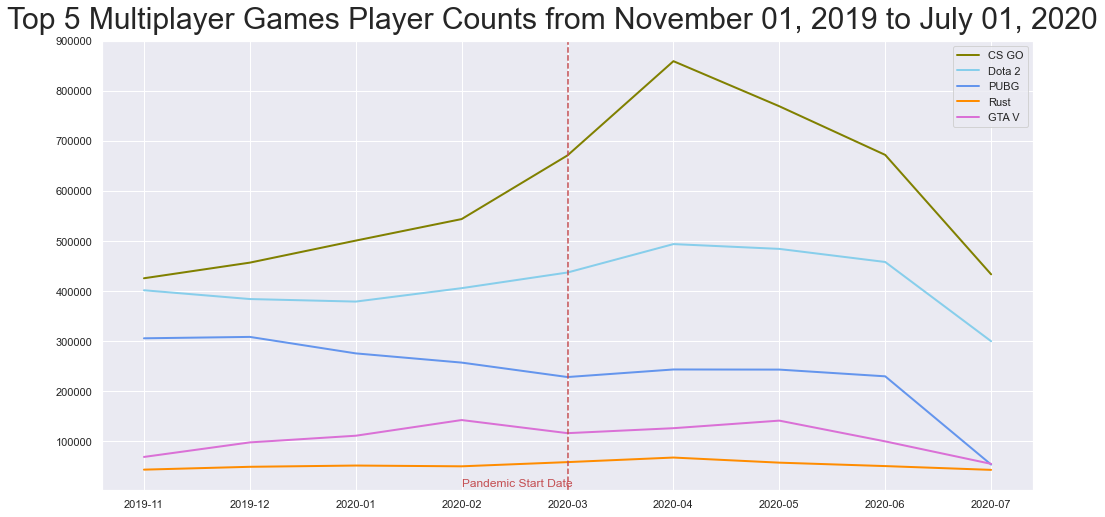

In [36]:
y_values_dict = {}
for multi_player_game in multi_player_IDs:
    dates = plotGame(multi_player_game, range_start_date, range_end_date, pandemic_y_values_dict)

# Merge all games into one dataframe (loop thorough dict keys with same key value -> concat to one df )
pandemic_games_df =pd.DataFrame({ 'Date': dates , 
                                  game_ID_dict[730]: pandemic_y_values_dict[730],
                                  game_ID_dict[570]: pandemic_y_values_dict[570], 
                                  game_ID_dict[578080]: pandemic_y_values_dict[578080],
                                  game_ID_dict[252490]: pandemic_y_values_dict[252490],
                                  game_ID_dict[271590]: pandemic_y_values_dict[271590]})
# Plot each game's player count history
plt.plot( 'Date', game_ID_dict[730], data=pandemic_games_df, marker='', color='olive', linewidth=2)
plt.plot( 'Date', game_ID_dict[570], data=pandemic_games_df, marker='', color='skyblue', linewidth=2) 
plt.plot( 'Date', game_ID_dict[578080], data=pandemic_games_df, marker='', color='cornflowerblue', linewidth=2)
plt.plot( 'Date', game_ID_dict[252490], data=pandemic_games_df, marker='', color='darkorange', linewidth=2)
plt.plot( 'Date', game_ID_dict[271590], data=pandemic_games_df, marker='', color='orchid', linewidth=2)
plt.figtext(.5,.9,'Top 5 Multiplayer Games Player Counts from November 01, 2019 to July 01, 2020', fontsize=30, ha='center')
plt.axvline(x='2020-03', linestyle='--', color = 'r')
plt.text(3,10000,'Pandemic Start Date',color='r',fontsize=12)
#plt.title('Top 5 Multiplayer Games Player Counts from March 2020 to June 2020')
plt.legend();

In [37]:
pre_y_values_dict = {} # Collect all y-values for each game

for multi_player_game in multi_player_IDs:
    dates = plotGame(multi_player_game, range_pre_start_date, range_pre_end_date, pre_y_values_dict)

In [38]:
pandemic_y_values_dict = {} # Collect all y-values for each game

for multi_player_game in multi_player_IDs:
    dates = plotGame(multi_player_game, range_post_start_date, range_post_end_date, pandemic_y_values_dict)

In [39]:
y_values_dict = {}
perc_csgo = findPercentIncrease(730)
perc_dota = findPercentIncrease(570)
perc_pubg = findPercentIncrease(578080) 
perc_rust = findPercentIncrease(252490) 
perc_gta_v = findPercentIncrease(271590) 
games_and_perc = {'Game': ['CS GO',
                           'Dota 2',
                           'PUBG',
                           'Rust',
                           'GTA V'],
                  'Percent Increase in Player Counts': [perc_csgo, 
                            perc_dota, 
                            perc_pubg, 
                            perc_rust, 
                            perc_gta_v] }
print(games_and_perc)

{'Game': ['CS GO', 'Dota 2', 'PUBG', 'Rust', 'GTA V'], 'Percent Increase in Player Counts': [41.662009422466696, 10.82528392902946, -30.362385326889314, 14.220974428071303, 2.501969555118045]}


Text(0.5, 0.9, 'Percent Change in Player Counts for 5 Most Popular Multiplayer Games')

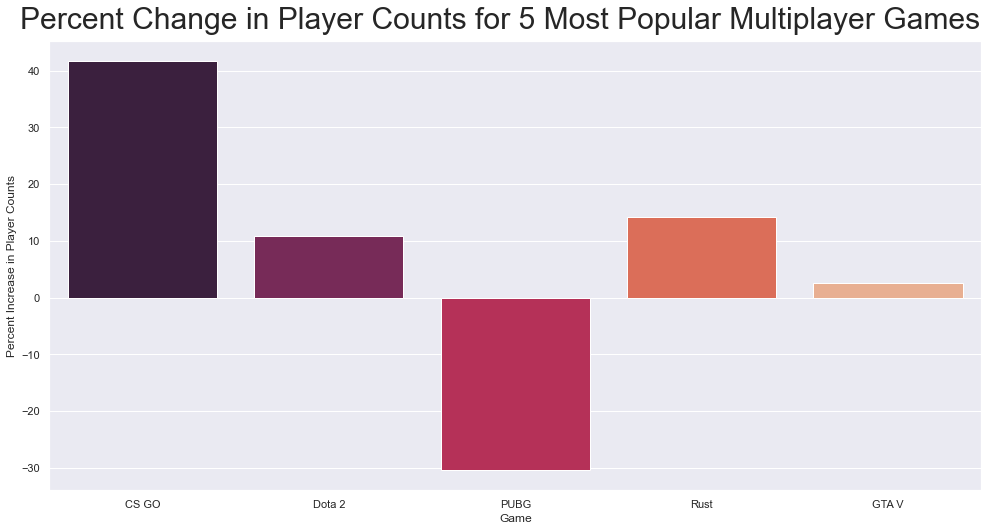

In [44]:
perc_change = pd.DataFrame(games_and_perc, columns=['Game','Percent Increase in Player Counts'])
ax = sns.barplot(x="Game", y="Percent Increase in Player Counts", data=perc_change, palette='rocket')
plt.figtext(.5,.9,'Percent Change in Player Counts for 5 Most Popular Multiplayer Games', fontsize=30, ha='center')


## Generalizing to All Games

We want to find the top 10 games with highest increase in player counts from the 4 month time period before the pandemic and the 4 month time period after the pandemic. Using our combined_reduced dataframe, we looked at the games that were also present in the Player Counts History Part 1 folder. We want to first analyze the top 1000 applications, so we will look at games in the Player Counts History Part 1 folder.
- Player count was collected in 5-minutes intervals for the top 1000 applications (PlayerCountHistoryPart1.zip) and in 1-hour intervals for the next 1000 applications(PlayerCountHistoryPart2.zip)

First, we will load all the file names from PlayerCountHistoryPart1 folder and store that in a list. Then using the path_leaf function, it returns only the ID part of the csv file paths we stored int he list earlier.

In [41]:
player_count_file_names1 = glob.glob('./datasets/PlayerCountHistoryPart1/*.csv')

def path_leaf(path):
    head, tail = ntpath.split(path)
    tail = tail.replace('.csv', '')
    return int(tail)


In [42]:
'''
Input: Game ID  
Output: Percent increase of player counts from 4 months before and 4 months after the pandemic
'''
def findPercentIncreaseImproved(gameID):
    # (1) Find player counts for 4 months before pandemic
    pre_y_values_dict = {}
    plotGame(gameID, range_pre_start_date, range_pre_end_date, pre_y_values_dict) 
    # (2) Find player counts for 4 months after pandemic
    pandemic_y_values_dict = {}  
    plotGame(gameID, range_post_start_date, range_post_end_date, pandemic_y_values_dict)   
    # (3) Find average of player counts from November 2019 to February 2020 for each game
    pre_game = statistics.mean(pre_y_values_dict[gameID])
    # (4) Find average of player counts from March 2020 to June 2020 for each game
    post_game = statistics.mean(pandemic_y_values_dict[gameID])
    perc_increase = (post_game - pre_game) / pre_game * 100
    return perc_increase

Cross reference with the ID's present in the combined_reduced dataset, we only look for the percent change in player count comparing pre and during the pandemic for csv files with ID's matching that of the combined_reduced data set.

In [43]:
all_IDs = list(combined_reduced['ID'])
percent_change_dict = {}
for fileName in player_count_file_names1:
    currID = path_leaf(fileName)
    if currID in all_IDs:
        percent_change_dict.setdefault(currID,findPercentIncreaseImproved(currID))
#percent_change_dict


In [45]:
len(percent_change_dict)

893

In [46]:
sorted_dict = dict( sorted(percent_change_dict.items(),
                           key=lambda item: item[1],
                           reverse=True))
len(sorted_dict)

893

In [47]:
# games with the highest percent increase in player count
top_10_perc_change = {k: sorted_dict[k] for k in list(sorted_dict)[:10]}

In [48]:
# getting names of those games using ID's
top_10_names = {}
for k in top_10_perc_change.keys():
    currName = (combined_reduced[combined_reduced['ID'] == k].name.to_string())[7:]
    top_10_names.setdefault(k, currName)
top_10_names

{551670: 'TWIN BROS',
 438020: 'AI: Rampage',
 444490: 'POLYWAR',
 461880: 'Hyposphere',
 412290: 'The Dreamlord',
 473470: 'Purgatory',
 504880: 'Pixel Puzzles 2: RADical ROACH',
 533340: 'Captivity',
 448470: 'Bacteria',
 513620: 'SkyTime'}

In [49]:
# saving the dictionary of percent change from PlayerCountHistoryPart1 as a csv file for later use

with open('./datasets/dictPlayCount1.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in sorted_dict.items():
       writer.writerow([key, value])

In [50]:
# for use later since loading all files took a long time
#with open('./datasets/dictPlayCount1.csv') as csv_file:
    #reader = csv.reader(csv_file)
    #mydict = dict(reader)